In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.transforms import GaussianBlur, ToTensor, ToPILImage, RandomCrop, Compose, Resize, Normalize
from torchvision.datasets import CIFAR10, Flickr8k, CelebA
from torch.utils.data import DataLoader

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set hyperparameters
num_epochs = 10
batch_size = 32
learning_rate = 0.001
image_size = 28

# Gaussian Pyramid Constants
num_scales = 3
scale_factor = 2

# Define the transformations to apply to the CIFAR-10 data
data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

download = True
# Define the training and test datasets
train_dataset = datasets.Flowers102(root='./data', split="train", download=download, transform=data_transforms)

# Define the dataloaders to load the data in batches during training and testing
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
dataloader = train_loader

In [5]:
# Define the network architecture with feature pyramid
class CompletionModel(nn.Module):
    def __init__(self, num_scales=3):
        super(CompletionModel, self).__init__()
        self.num_scales = num_scales

        # Define layers for each scale in the feature pyramid
        self.encoders = nn.ModuleList()
        self.decoders = nn.ModuleList()
        self.channel_reducers = nn.ModuleList()  # 1x1 convolution layers to reduce channels
#         self.downsamplers = nn.ModuleList()
#         self.upsamplers = nn.ModuleList()
        
        for i in range(num_scales):
            encoder = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
                nn.ReLU(),
                nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
                nn.ReLU(),
                nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
                nn.ReLU(),
                nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
                nn.ReLU()
            )
            self.encoders.append(encoder)

            decoder = nn.Sequential(
                nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU()
            )
            self.decoders.append(decoder)
            
            channel_reducer = nn.Conv2d(3, 512, kernel_size=1)  # 1x1 convolution layer to reduce channels
            self.channel_reducers.append(channel_reducer)
            
        self.upsampler = nn.Upsample(scale_factor=scale_factor, mode='bilinear', align_corners=False)
        self.downsampler = nn.Upsample(scale_factor=1/scale_factor, mode='bilinear', align_corners=False)
            

    def forward(self, x):
        # Initialize list to store features from each scale
        features = []
        #print(f"x.shape: {x.shape}")

        # Forward pass through each scale in the feature pyramid
        for i in range(self.num_scales):
            encoder_output = self.encoders[i](x)
            features.append(encoder_output)
            #print(f"Feature size at {i}th scale: {features[-1].shape}")
            x = self.downsampler(x)

        # Decode the concatenated features
        shape_feats = list(features[-1].shape)
        shape_feats[1] = 3
        prev_output = None#torch.zeros(shape_feats).to(device)
        
        for i in range(self.num_scales):
            decoder_output = self.decoders[i](features[self.num_scales - i - 1])
            #print(f"decoder output shape: {decoder_output.shape}")
            if prev_output is None:
                prev_output = self.upsampler(decoder_output)
            else:
                #prev_output = self.channel_reducers[i](prev_output)
                prev_output = self.upsampler(prev_output+decoder_output)
            #print(f"prev_output.shape : {prev_output.shape}")
        
        #print(decoder_output.shape)
        return decoder_output


In [3]:
model = CompletionModel().to(device)

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 50

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, _ in dataloader:
        images = images.to(device)
        
        occluded_image = images.clone()
        _, _, h, w = occluded_image.shape
        x = torch.randint(0, w // 2, (1,))
        y = torch.randint(0, h // 2, (1,))
        occluded_image[:, :, y:y + h // 2, x:x + w // 2] = 0
        # Forward pass and loss calculation
        completion_images = model(occluded_image.to(device))
        loss = criterion(completion_images[:, :, y:y + h // 2, x:x + w // 2], images[:, :, y:y + h // 2, x:x + w // 2])
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Compute the average loss for the epoch
    average_loss = running_loss / len(dataloader)
    
    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")

# Generate completions for test images
model.eval()
pass

Epoch [1/50], Loss: 0.1960
Epoch [2/50], Loss: 0.1508
Epoch [3/50], Loss: 0.0888
Epoch [4/50], Loss: 0.0793
Epoch [5/50], Loss: 0.0686
Epoch [6/50], Loss: 0.0655
Epoch [7/50], Loss: 0.0651
Epoch [8/50], Loss: 0.0629
Epoch [9/50], Loss: 0.0618
Epoch [10/50], Loss: 0.0610
Epoch [11/50], Loss: 0.0600
Epoch [12/50], Loss: 0.0612
Epoch [13/50], Loss: 0.0607
Epoch [14/50], Loss: 0.0603
Epoch [15/50], Loss: 0.0588
Epoch [16/50], Loss: 0.0584
Epoch [17/50], Loss: 0.0592
Epoch [18/50], Loss: 0.0658
Epoch [19/50], Loss: 0.0608
Epoch [20/50], Loss: 0.0586
Epoch [21/50], Loss: 0.0569
Epoch [22/50], Loss: 0.0563
Epoch [23/50], Loss: 0.0591
Epoch [24/50], Loss: 0.0561
Epoch [25/50], Loss: 0.0566
Epoch [26/50], Loss: 0.0549
Epoch [27/50], Loss: 0.0572
Epoch [28/50], Loss: 0.0539
Epoch [29/50], Loss: 0.0541
Epoch [30/50], Loss: 0.0519
Epoch [31/50], Loss: 0.0509
Epoch [32/50], Loss: 0.0503
Epoch [33/50], Loss: 0.0485
Epoch [34/50], Loss: 0.0492
Epoch [35/50], Loss: 0.0479
Epoch [36/50], Loss: 0.0475
E

In [4]:
edge_len = int(128/8)
encoded = model.encoders[0](torch.randn((64, 3, edge_len, edge_len)).to(device))
print(encoded.shape)
model.decoders[0](encoded).shape

torch.Size([64, 512, 1, 1])


torch.Size([64, 3, 16, 16])

In [8]:
model = CompletionModel().to(device)
model.load_state_dict(torch.load('ssl_model.pth'))
# # Define the loss function
# criterion = nn.MSELoss()

# # Define the optimizer
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)


<All keys matched successfully>

In [1]:
def unnormalize(img):
    # Define the mean and standard deviation values used for normalization
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    # Define the un-normalization transform
    unnormalize = transforms.Normalize(mean=[-m/s for m, s in zip(mean, std)], std=[1/s for s in std])

    # Apply un-normalization to the occluded_image
    unnormalized_img = unnormalize(img.cpu().squeeze(0))
    return unnormalized_img

In [12]:
from IPython.display import display, HTML

# # Define test transformations
# test_transform = Compose([
#     ToTensor()
# ])
test_dataset = datasets.Flowers102(root='./data', split="test", download=download, transform=data_transforms)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)

# Load CIFAR-10 test dataset
# test_dataset = CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# # Create test data loader
# test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

with torch.no_grad():
    i = 0
    for images, _ in test_dataloader:
        images = images.to(device)
        
        occluded_image = images.clone()
        _, _, h, w = occluded_image.shape
        x = torch.randint(0, w // 2, (1,))
        y = torch.randint(0, h // 2, (1,))
        occluded_image[:, :, y:y + h // 2, x:x + w // 2] = 0
        
        ########
        
        # Generate completions using the model
        completions = model(occluded_image.to(device))

        # Convert tensors to PIL images for visualization
        to_pil = ToPILImage()
        true_img = to_pil(unnormalize(images.cpu().squeeze(0)))
        original_img = to_pil(unnormalize(occluded_image.cpu().squeeze(0)))
        
        occluded_image[:, :, y:y + h // 2, x:x + w // 2] = completions[:, :, y:y + h // 2, x:x + w // 2]
        completed_img = to_pil(unnormalize(occluded_image.cpu().squeeze(0)))
        
        # Define the HTML style for larger images
        html_style = "<style>img { max-width: 100%; height: auto; }</style>"
        i+=1
        if i==3:
            break

        # Display the original and completed images with larger size
#         display(HTML(html_style))

#         # Display the original and completed images
#         display(original_img)
#         display(completed_img)

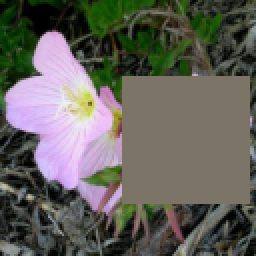

In [13]:
from PIL import Image
original_img.resize((original_img.width * 2,original_img.height * 2),
                                                    Image.NEAREST)


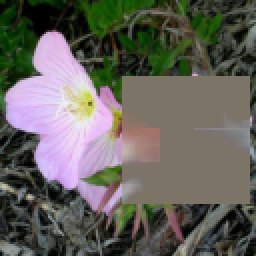

In [14]:
completed_img.resize((completed_img.width * 2,completed_img.height * 2),
                                                    Image.NEAREST)

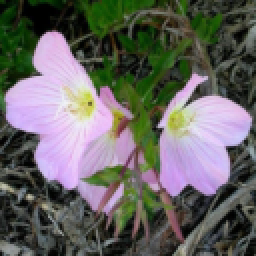

In [15]:
true_img.resize((true_img.width * 2,true_img.height * 2),
                                                    Image.NEAREST)


## Downstream evaluation

In the SSL model trained above, we have multiple encoders. All of these specialize in capturing the information at a specific level.

In [74]:
# torch.save(model.state_dict(), 'ssl_model.pth')

In [16]:
model = CompletionModel().to(device)
model.load_state_dict(torch.load('ssl_model.pth'))

input_shape = (256, 128, 128)
# Define the classification model
classification_model = nn.Sequential(
    # Convolutional layers
    nn.AdaptiveAvgPool2d((1, 1)),
#     # Flatten the feature maps
    nn.Flatten(),

#     # Fully connected layers
    nn.Linear(num_scales*512, 256),
    nn.ReLU(),
    nn.Linear(256, 102)  # num_classes is the number of classes for classification
)


def model_eval(model, classification_model, dataloader):
    
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            
            encoder_outputs = []
            for j in range(num_scales):
                encoder_outputs.append(model.encoders[j](images))
            encoder_outputs_stacked = torch.cat(encoder_outputs, dim=1)
            outputs = classification_model(encoder_outputs_stacked)
        
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
#             print(predicted.shape, labels.shape, total, images.shape, outputs.data.shape)
#             print(encoder_outputs_stacked.shape)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam([{'params': classification_model.parameters()}, {'params': model.parameters()}], lr=learning_rate)

num_epochs = 50
classification_model = classification_model.to(device)

log_train_every = 1
log_test_every = 5

trainLoss_ssl, trainAcc_ssl, testAcc_ssl = [], [], []

for epoch in range(num_epochs):
    running_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        
        encoder_outputs = []
        for j in range(num_scales):
            encoder_outputs.append(model.encoders[j](inputs))
        encoder_outputs_stacked = torch.cat(encoder_outputs, dim=1)
        outputs = classification_model(encoder_outputs_stacked)
        
        loss = criterion(outputs, labels)
        
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    # compute training & testing accuracy every couple of iterations        
    if (epoch+1) % log_train_every == 0:
        train_accuracy = model_eval(model, classification_model, train_loader)

        # Log the loss
        #writer.add_scalar('Loss/train', loss.cpu().item(), epoch * len(train_loader) + i)

        # Log the training accuracy
        #writer.add_scalar('Accuracy/train', train_accuracy, epoch * len(train_loader) + i)
        print(f"Epoch {epoch+1} : Loss: {running_loss} Accuracy: {train_accuracy}")
        trainLoss_ssl.append(running_loss)
        trainAcc_ssl.append(train_accuracy)
        
    if (epoch+1) % log_test_every == 0:
        test_accuracy = model_eval(model, classification_model, test_dataloader)

        # Log the test accuracy
        #writer.add_scalar('Accuracy/test', test_accuracy, epoch * len(train_loader) + i)
        print(f"Epoch {epoch+1} : Test Accuracy: {test_accuracy}")
        testAcc_ssl.append(test_accuracy)
        
# writer.close()
print("Training finished.")

Epoch 1 : Loss: 73.58275604248047 Accuracy: 3.9215686274509802
Epoch 2 : Loss: 67.8311915397644 Accuracy: 4.411764705882353
Epoch 3 : Loss: 62.179434299468994 Accuracy: 11.372549019607844
Epoch 4 : Loss: 57.450071811676025 Accuracy: 15.0
Epoch 5 : Loss: 53.34681439399719 Accuracy: 18.823529411764707
Epoch 5 : Test Accuracy: 13.579443812001951
Epoch 6 : Loss: 50.43138384819031 Accuracy: 22.352941176470587
Epoch 7 : Loss: 47.5905864238739 Accuracy: 30.88235294117647
Epoch 8 : Loss: 43.742791175842285 Accuracy: 36.27450980392157
Epoch 9 : Loss: 39.83317828178406 Accuracy: 40.78431372549019
Epoch 10 : Loss: 36.377209186553955 Accuracy: 46.666666666666664
Epoch 10 : Test Accuracy: 20.084566596194502
Epoch 11 : Loss: 33.389787673950195 Accuracy: 48.627450980392155
Epoch 12 : Loss: 30.12665295600891 Accuracy: 53.23529411764706
Epoch 13 : Loss: 26.73465871810913 Accuracy: 64.11764705882354
Epoch 14 : Loss: 22.41390895843506 Accuracy: 66.17647058823529
Epoch 15 : Loss: 19.428902864456177 Accura

## Training without SSL

In [19]:
# for i in range(num_scales):
#     model.encoders[i] = nn.Sequential(
#         nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
#         nn.ReLU(),
#         nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
#         nn.ReLU(),
#         nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
#         nn.ReLU(),
#         nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
#         nn.ReLU()
#     )

model = CompletionModel().to(device)

classification_model_nonssl = nn.Sequential(
    # Convolutional layers
    nn.AdaptiveAvgPool2d((1, 1)),
#     # Flatten the feature maps
    nn.Flatten(),

#     # Fully connected layers
    nn.Linear(num_scales*512, 256),
    nn.ReLU(),
    nn.Linear(256, 102)  # num_classes is the number of classes for classification
)

def model_eval_nonssl(model, classification_model, dataloader):
    
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            
            encoder_outputs = []
            for j in range(num_scales):
                encoder_outputs.append(model.encoders[j](images))
            encoder_outputs_stacked = torch.cat(encoder_outputs, dim=1)
            outputs = classification_model(encoder_outputs_stacked)
        
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
#             print(predicted.shape, labels.shape, total, images.shape, outputs.data.shape)
#             print(encoder_outputs_stacked.shape)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy


num_epochs = 50
classification_model = classification_model.to(device)
model = model.to(device)

log_train_every = 1
log_test_every = 5

trainLoss_nonssl, trainAcc_nonssl, testAcc_nonssl = [], [], []

criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam([{'params': classification_model.parameters()}, {'params': model.parameters()}], lr=learning_rate)

for epoch in range(num_epochs):
    running_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        
        encoder_outputs = []
        for j in range(num_scales):
            encoder_outputs.append(model.encoders[j](inputs))
        encoder_outputs_stacked = torch.cat(encoder_outputs, dim=1)
        outputs = classification_model(encoder_outputs_stacked)
        
        loss = criterion(outputs, labels)
        
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    # compute training & testing accuracy every couple of iterations        
    if (epoch+1) % log_train_every == 0:
        train_accuracy = model_eval(model, classification_model, train_loader)

        # Log the loss
        #writer.add_scalar('Loss/train', loss.cpu().item(), epoch * len(train_loader) + i)

        # Log the training accuracy
        #writer.add_scalar('Accuracy/train', train_accuracy, epoch * len(train_loader) + i)
        print(f"Epoch {epoch+1} : Loss: {running_loss} Accuracy: {train_accuracy}")
        trainLoss_nonssl.append(running_loss)
        trainAcc_nonssl.append(train_accuracy)
        
    if (epoch+1) % log_test_every == 0:
        test_accuracy = model_eval(model, classification_model, test_dataloader)
        testAcc_nonssl.append(test_accuracy)

        # Log the test accuracy
        #writer.add_scalar('Accuracy/test', test_accuracy, epoch * len(train_loader) + i)
        print(f"Epoch {epoch+1} : Test Accuracy: {test_accuracy}")
        
# writer.close()
print("Training finished.")

Epoch 1 : Loss: 69.89324522018433 Accuracy: 4.901960784313726
Epoch 2 : Loss: 57.258018255233765 Accuracy: 14.901960784313726
Epoch 3 : Loss: 48.15808415412903 Accuracy: 28.92156862745098
Epoch 4 : Loss: 40.13304948806763 Accuracy: 34.11764705882353
Epoch 5 : Loss: 35.912060141563416 Accuracy: 42.15686274509804
Epoch 5 : Test Accuracy: 18.946170108960807
Epoch 6 : Loss: 30.881222009658813 Accuracy: 50.78431372549019
Epoch 7 : Loss: 28.56290030479431 Accuracy: 48.72549019607843
Epoch 8 : Loss: 26.45223081111908 Accuracy: 52.64705882352941
Epoch 9 : Loss: 25.121849179267883 Accuracy: 61.1764705882353
Epoch 10 : Loss: 22.219290018081665 Accuracy: 62.450980392156865
Epoch 10 : Test Accuracy: 20.60497641892991
Epoch 11 : Loss: 20.430411338806152 Accuracy: 62.745098039215684
Epoch 12 : Loss: 19.825640976428986 Accuracy: 65.58823529411765
Epoch 13 : Loss: 17.846860349178314 Accuracy: 71.17647058823529
Epoch 14 : Loss: 16.68001139163971 Accuracy: 75.98039215686275
Epoch 15 : Loss: 15.511822938

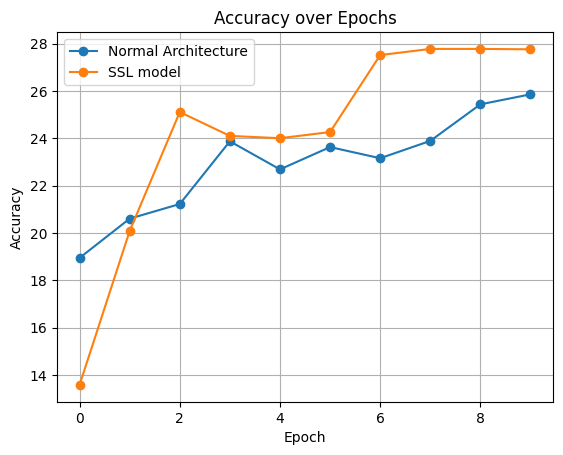

In [32]:
import matplotlib.pyplot as plt

epochs = range(len(testAcc_nonssl))

plt.plot(epochs, testAcc_nonssl, marker='o', label='Normal Architecture')
plt.plot(epochs, testAcc_ssl, marker='o', label='SSL model')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()